In [2]:
from IPython.display import display
from IPython.display import Image
import os # Locate files

# A small demo to show how to wish a happy new year with X-ray simulation
## Authors: F. P. Vidal

**Purpose:** In this notebook, we wish a happy new year 2022. 

**Material and Methods:** For this purpose, we create 3D models using [OpenSCAD](https://openscad.org/) (the Programmers Solid 3D CAD Modeller). In our simulation the source-to-object distance (SOD) is 10cm, and the source-to-detector distance (SDD) is 115cm. The beam spectrum is polychromatic. The voltage is 50 kV. The filteration is 0.5 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator.

In [3]:
Image(filename="setup.png")

The scanned object is made of two materials, a background plate of "muscle", and a new year message of bone (cortical). We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

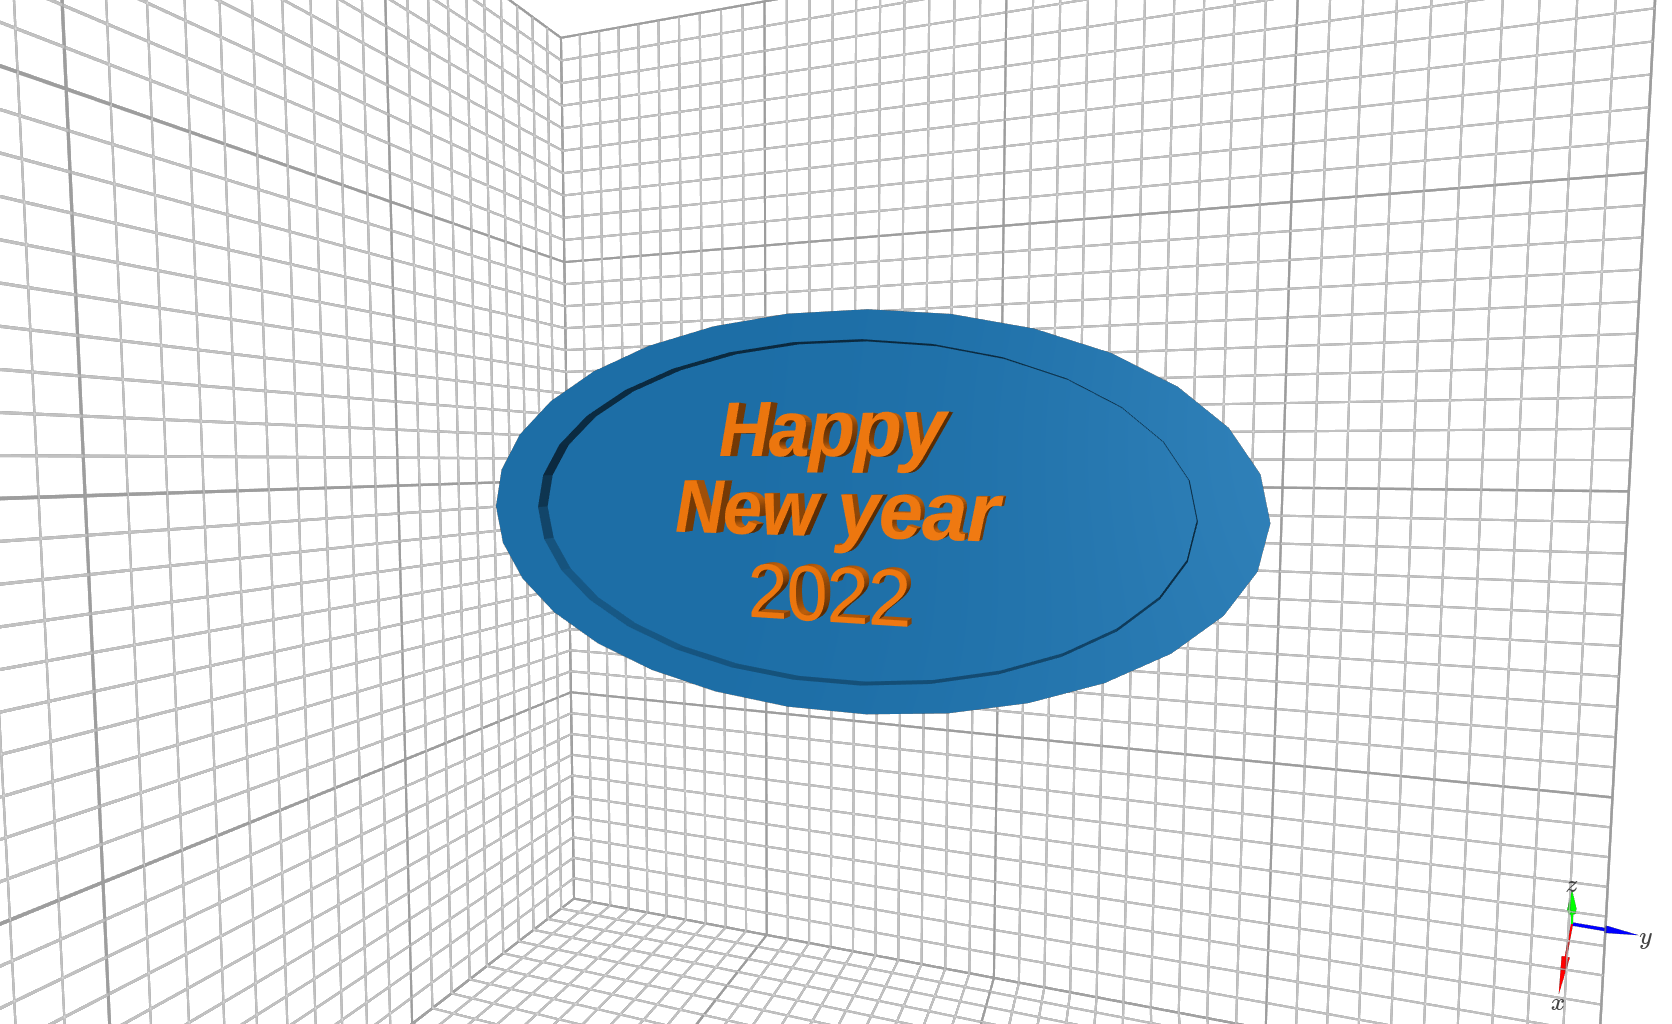

In [4]:
Image(filename="visualisation.png", width=800)

**Results:** A X-ray CT data acquisition is simulated using gVirtualXRay, our opensource library to simulate X-ray image. The reconstructed volume conveys our best wishes for 2022.

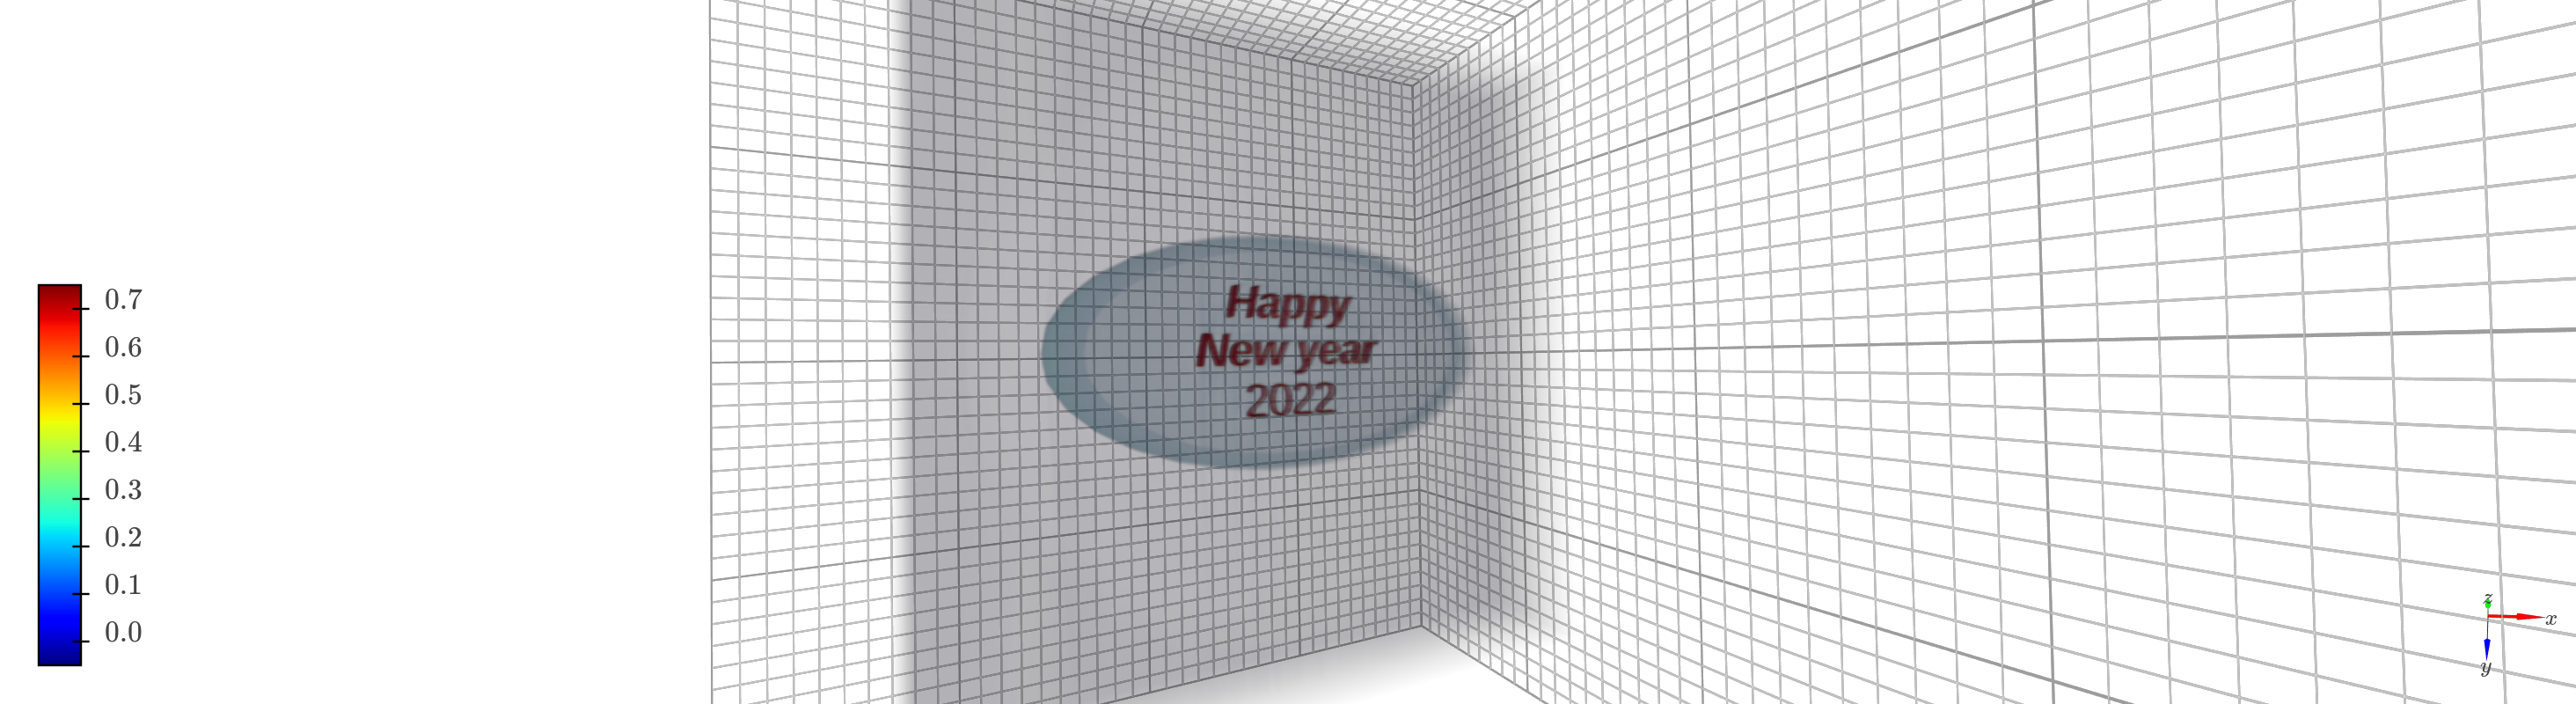

In [5]:
Image(filename="volume_rendering.png", width=800)

## Import packages

In [7]:
%matplotlib inline

# import urllib # Download file
# import zipfile # Unzip the file

import math
import numpy as np # Who does not use Numpy?
# import pandas as pd # Load/Write CSV files

import matplotlib
import matplotlib.pyplot as plt # Plotting

import viewscad # Use OpenSCAD to create STL files

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up


# from matplotlib.cm import get_cmap
# from matplotlib.colors import LogNorm # Look up table
# from matplotlib.colors import PowerNorm # Look up table
# import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

# from skimage.transform import iradon

# from scipy.stats import pearsonr # Compute the correlatio coefficient

# from skimage.util import compare_images # Checkboard comparison between two images
# from skimage.metrics import structural_similarity as ssim
# from sklearn.metrics import mean_absolute_percentage_error as mape
# from skimage.metrics import structural_similarity as ssim
# from skimage.transform import resize # Resample the images

from tifffile import imread, imsave # Load/Write TIFF files
import imageio

from scipy.ndimage import zoom, rotate


# import datetime # For the runtime

import k3d, base64 # For visualisation
import SimpleITK as sitk
from stl import mesh
# import random
# from sitk2vtk import sitk2vtk

# import gvxrPython3 as gvxr # Simulate X-ray images

# import json2gvxr # Set gVirtualXRay and the simulation up
# from utils import * # Code shared across more than one notebook

SimpleGVXR 1.0.1 (2022-03-10T15:28:42) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2022-03-10T15:28:36) [Compiler: GNU g++] on Linux


## Define some useful functions

In [8]:
total_energy = None

def flatFieldCorrection(proj):
    
    global total_energy
    
    if total_energy is None:

        # Retrieve the total energy
        total_energy = 0.0;
        energy_bins = gvxr.getEnergyBins("MeV");
        photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

        for energy, count in zip(energy_bins, photon_count_per_bin):
            total_energy += energy * count;

    # Create a mock dark field image
    #dark_field_image = np.zeros(raw_projections.shape);
    dark_field_image = 0.0

    # Create a mock flat field image
    #flat_field_image = np.ones(raw_projections.shape);
    flat_field_image = 1.0

    flat_field_image *= total_energy
    
    return (np.array(proj).astype(np.single) - dark_field_image) / (flat_field_image - dark_field_image)

In [9]:
def minusLog(proj):

    minus_log_projs = np.copy(proj)
    
    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
    threshold = 0.000000001
    minus_log_projs[minus_log_projs < threshold] = threshold;

    # Apply the minus log normalisation
    minus_log_projs = -np.log(minus_log_projs);

    # Rescale the data taking into account the pixel size
    pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
    minus_log_projs /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

    # Make sure the data is in single-precision floating-point numbers
    return minus_log_projs.astype(np.single)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [10]:
json2gvxr.initGVXR("notebook.json", "OPENGL")

Create an OpenGL context: 500x500
Wed Mar 16 15:20:30 2022 ---- Create window gvxrStatus:	Create window 


0



0 0 500 500
OpenGL renderer:   GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 455.45.01
OpenGL vender:     NVIDIA Corporation
Wed Mar 16 15:20:30 2022 ---- Use OpenGL 4.5.0 0 500 500


## Create the 3D models

We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files. We adapt the ["sign"](https://github.com/openscad/openscad/tree/master/examples/Parametric) example from OpenSCAD.

In [11]:
openscad_make_text_str = """

//The resolution of the curves. Higher values give smoother curves but may increase the model render time.
resolution = 100; //[10, 20, 30, 50, 100]

//Total height of the sign
height = 5;//[1 : 10]

$fn = resolution;

//rotate(-90, [1, 0, 0])
    linear_extrude(height = height) {
        translate([0, height * 2]) text("gVirtualXRay", halign = "center", font="Liberation Sans:style=Bold Italic");
        //translate([0, -height+ 1]) text("New year", halign = "center", font="Liberation Sans:style=Bold Italic");
        //translate([0, -height * 4 + 1]) text("2022", halign = "center");
}
"""

In [12]:
fname = 'bonne_annee.stl'
if True: #not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_make_text_str, outfile=fname)

Geometries in cache: 3
Geometry cache size in bytes: 378904
CGAL Polyhedrons in cache: 0
CGAL cache size in bytes: 0
Total rendering time: 0:00:00.026
   Top level object is a 3D object:
   Facets:       4716


In [13]:
openscad_make_frame_str = """

//The resolution of the curves. Higher values give smoother curves but may increase the model render time.
resolution = 100; //[10, 20, 30, 50, 100]

//The horizontal radius of the outer ellipse of the sign.
radius = 70;//[60 : 200]

//Total height of the sign
height = 5;//[1 : 10]

$fn = resolution;

//rotate(-90, [1, 0, 0])
    scale([1, 0.5]) difference() {
        cylinder(r = radius, h = 2 * height, center = true);
        translate([0, 0, height])
            cylinder(r = radius - 10, h = height + 1, center = true);
    }
"""

In [14]:
fname = 'frame.stl'
if True: #not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_make_frame_str, outfile=fname)

CGAL Cache insert: difference(){cylinder($fn=0,$fa=12,$fs=2 (162128 bytes)
CGAL Cache insert: multmatrix([[1,0,0,0],[0,0.5,0,0],[0,0,1 (162128 bytes)
Geometries in cache: 3
Geometry cache size in bytes: 13416
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 324256
Total rendering time: 0:00:00.064
   Top level object is a 3D object:
   Simple:        yes
   Vertices:      120
   Halfedges:     360
   Edges:         180
   Halffacets:    126
   Facets:         63
   Volumes:         2


Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [15]:
json2gvxr.initSamples(verbose=0)

frame.stl	nb_faces:	236	nb_vertices:	708	bounding_box (in cm):	(-7, -3.48083, -0.5)	(7, 3.48083, 0.5)
bonne_annee.stl	nb_faces:	4716	nb_vertices:	14148	bounding_box (in cm):	(-4.20058, 0.711801, 0)	(4.27153, 2.00634, 0.5)


In [16]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    fname = sample["Path"]
    
    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)
    print(fname, R, G,B,A)
    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity = 1)
    
    plot += geometry   
    
plot.display()
plot.camera = [51.23248565623175,      9.126419654587167, 150.48234089390888,
                0,                     0,                   0,
               -0.0026482914493697013, 0.9999958402233124, -0.0011428422968683257]

frame.stl 31 119 180 255
bonne_annee.stl 255 127 14 255


Output()

In [17]:
fname = 'visualisation.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    plot.fetch_screenshot()

    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

## X-ray source

We create an X-ray source. It is a point source.

In [34]:
json2gvxr.initSourceGeometry("notebook.json")

Set up the beam
	Source position: [0.0, 0.0, 0.75, 'm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic. Each projection is acquired using 0.5 mm aluminium filtration and at 50 kvp. 

In [19]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


params["Source"]["Beam"] {'kvp': 50, 'tube angle': 12, 'filter': [['Al', 0.5]]}
['Al', 0.5]


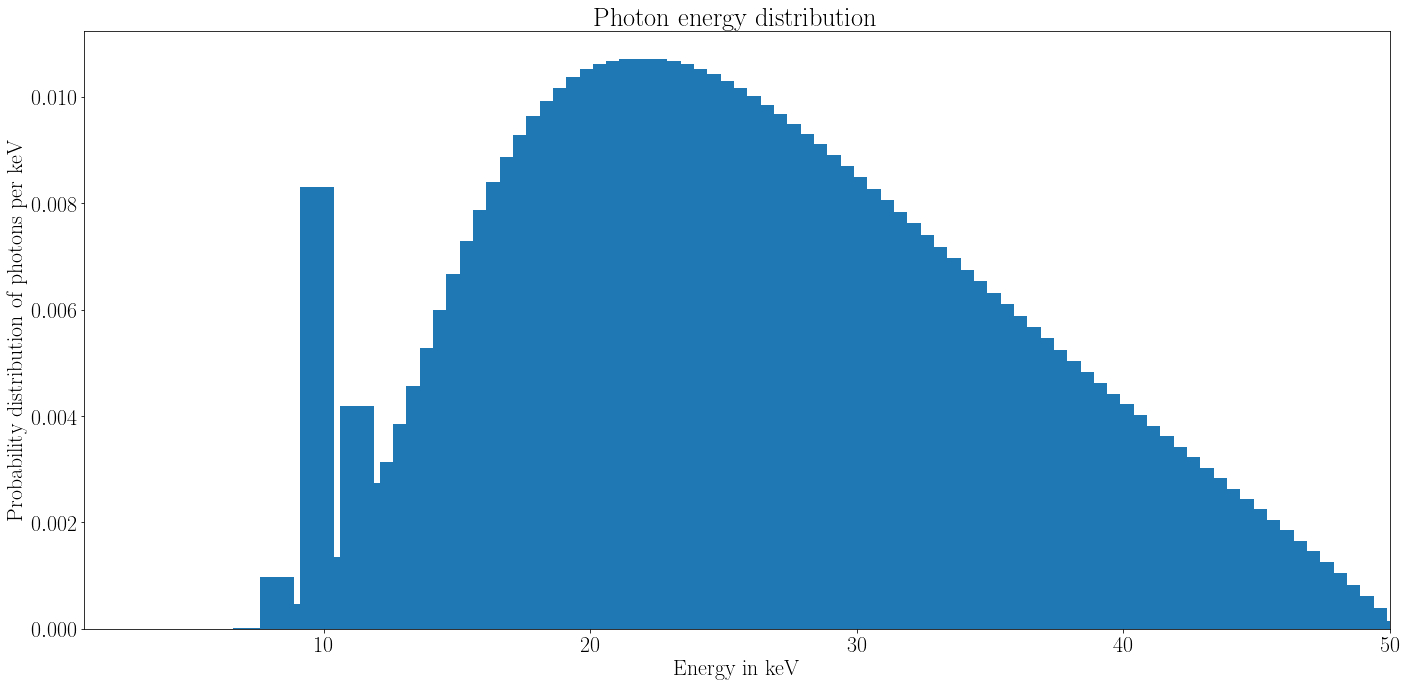

In [20]:
xlim=[np.min(k), np.max(k)]

plt.figure(figsize= (20,10))

plt.bar(k, f / f.sum()) # Plot the spectrum
plt.xlabel('Energy in keV')
plt.ylabel('Probability distribution of photons per keV')
plt.title('Photon energy distribution')

plt.xlim(xlim)

plt.tight_layout()

## Detector

Create a digital detector

In [33]:
json2gvxr.initDetector("notebook.json")

Set up the detector
	Detector position: [0.0, 0.0, -100.0, 'mm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [800, 150]
	Energy response: energyResponseDetector.txt in MeV
	Pixel spacing: [0.25, 0.25, 'mm']


In [22]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

## Model the energy response of the detector

Load the energy response

In [23]:
detector_response = np.loadtxt("energyResponseDetector.txt")

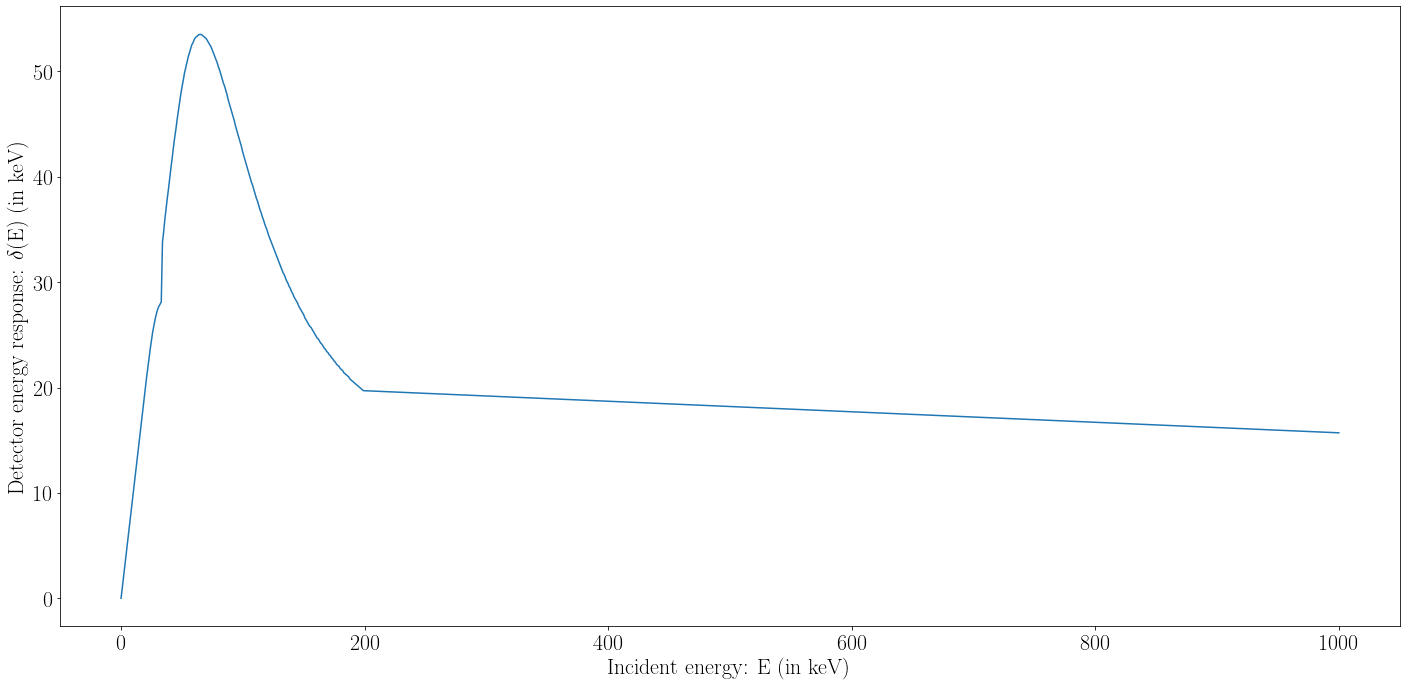

In [24]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [35]:
gvxr.displayScene()
temp = gvxr.computeXRayImage();

In [36]:
# gvxr.setWindowBackGroundColour(1, 1, 1)

# gvxr.setSceneRotationMatrix((1.0, 0.0, 0.0, 0.0,
#                              0.0, 1.0, 0.0, 0.0,
#                              0.0, 0.0, 1.0, 0.0, 
#                              0.0, 0.0, 0.0, 1.0))
# gvxr.setZoom(2000.6787109375)

# gvxr.displayScene()
# screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)
# plt.imsave("3d-env.png", screenshot)

In [37]:
gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(429.6787109375)
gvxr.setSceneRotationMatrix((0.5541335940361023,   -0.13906705379486084, -0.8207247853279114,  0.0,
                             0.8323286771774292,    0.07763540744781494,  0.5488126277923584,  0.0,
                            -0.012604578398168087, -0.9872260093688965,   0.15877097845077515, 0.0, 
                             0.0,                   0.0,                  0.0,                 1.0))

gvxr.displayScene()

In [38]:
screenshot = gvxr.takeScreenshot()

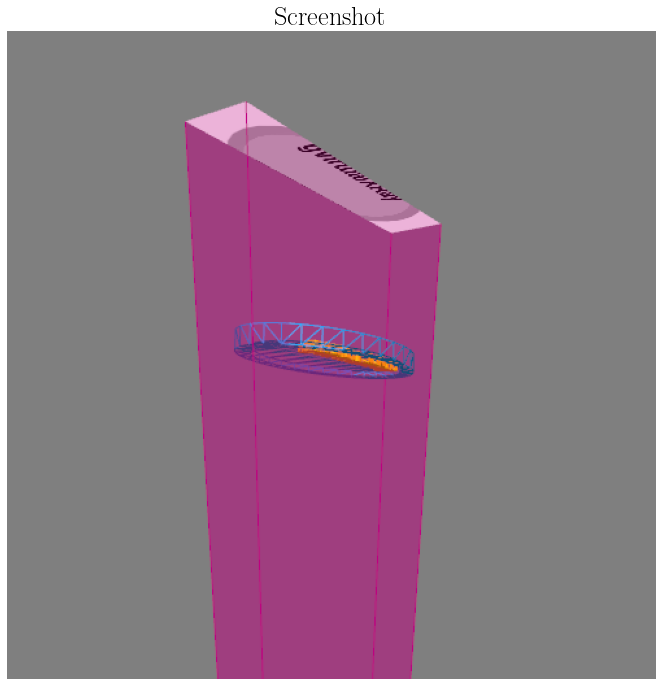

In [39]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

 Update set of projections while rotating the scene to mimick CT acquisition

In [30]:
%%capture

matplotlib.rcParams.update({'font.size': 42})

if not os.path.exists("CT_acquisition.gif"):

    raw_projections = [];

    # Create a GIF file
    writer = None
    fname_gif = "CT_acquisition.gif"

    # if not os.path.exists(fname_gif):
    writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()
    
    i = 0
    
    rotation_axis = json2gvxr.params["Detector"]["UpVector"]
    
    raw_projections_1D = []
    angles = []
    
    for angle_id in range(0, number_of_projections):

        # Compute an X-ray image    
        xray_image = np.array(gvxr.computeXRayImage());

        # Add to the set of projections
        raw_projections.append(xray_image)
        angles.append(angle_id * angular_step)
        
        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30 or angle_id == number_of_projections - 1:
       
                ncols = 3
                nrows = 1

                fig = plt.figure(figsize= (40, 20))

                ax = fig.add_subplot(nrows, ncols, 1)
                ax.set_title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                screenshot = gvxr.takeScreenshot()
                ax.set_title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')
                
                # Flat-field corrections
                corrected_projections = flatFieldCorrection(raw_projections)
                
                # Create a temporary image to hold the sinogram
                minus_log_projs = minusLog(corrected_projections)
                
                sinograms = np.swapaxes(minus_log_projs, 0, 1)

                # Reconstruction
                theta_rad = np.array(angles) * math.pi / 180
                CT_volume_in_mu = recons(minus_log_projs, -theta_rad)
                ct_shepp_filter_image = recons(minus_log_projs, -theta_rad, filter="hann")
                
                # fname = 'sinograms/temp_' + format(i, '04') + '.tif'
                # imsave(fname, minus_log_projs)
                
                ax = fig.add_subplot(nrows, ncols, 2)
                ax.set_title("Sinogram\n" + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(sinograms[61], cmap="gray", vmin=minus_log_projs.min(), vmax=minus_log_projs.max())
                plt.axis('off')
                
                ax = fig.add_subplot(nrows, ncols, 3)
                ax.set_title("FDK reconstruction\nwith " + str(angle_id + 1) + " angles")
                plt.imshow(np.rot90(ct_shepp_filter_image[61]), cmap="gray", vmin=0, vmax=ct_shepp_filter_image.max())
                plt.axis('off')

#                 fname = 'slices/temp_no_filter_' + format(i, '04') + '.tif'
#                 imsave(fname, ct_no_filter_image)

#                 fname = 'slices/temp_shepp_filter_' + format(i, '04') + '.tif'
#                 imsave(fname, ct_shepp_filter_image)

                plt.tight_layout()

                fname = 'render/temp_' + format(i, '04') + '.png'
                plt.savefig(fname, dpi=25)
                plt.close()

                # Add the image to the GIF file
                image = imageio.imread(fname)
                writer.append_data(image)                

                if angle_id == number_of_projections - 1:
                    for i in range(10):
                        writer.append_data(image)
                        print("Add last angle")

                i += 1
                

        # Rotate the sample
        gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2]);

    # Delete the temporary file
    # os.remove("temp.png")
    
    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

    # We're done with the writer
    if writer is not None:
        writer.close()
        # os.remove(temp.tif)

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

In [31]:
matplotlib.rcParams.update({'font.size': 22})

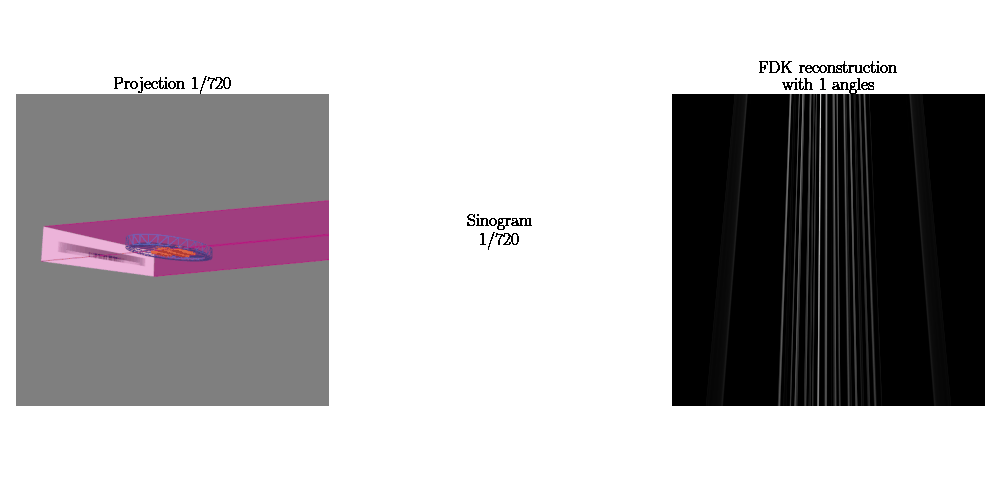

In [33]:
with open('CT_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

## Save the projections using SimpleITK

In [34]:
if not os.path.exists("raw_projections.mha"):

    raw_projections = np.array(raw_projections).astype(np.single)

    temp = sitk.GetImageFromArray(raw_projections)
    temp.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(temp, "raw_projections.mha", useCompression=True) 
else:
    temp = sitk.ReadImage("raw_projections.mha")
    raw_projections = sitk.GetArrayFromImage(temp)

# Perform flat-field correction

In [35]:
if not os.path.exists("flat.mha"):

    # Flat-field corrections
    corrected_projections = flatFieldCorrection(raw_projections)

    sitk_image = sitk.GetImageFromArray(corrected_projections)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, "flat.mha", useCompression=True) 

else:
    temp = sitk.ReadImage("flat.mha")
    corrected_projections = sitk.GetArrayFromImage(temp)
    
del raw_projections # Not needed anymore

## Calculate $-\log(\mathbf{corrected\_projections}) $ to linearize transmission tomography data

In [36]:
if not os.path.exists("sinograms.mha"):

    minus_log_projs = minusLog(corrected_projections)

    sitk_image = sitk.GetImageFromArray(minus_log_projs)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, "sinograms.mha", useCompression=True)
    
else:
    temp = sitk.ReadImage("sinograms.mha")
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
# Reformat the projections into a set of sinograms
sinograms = np.swapaxes(minus_log_projs, 0, 1)
sinograms = np.array(sinograms).astype(np.single)

del corrected_projections # Not needed anymore

Plot some sinograms

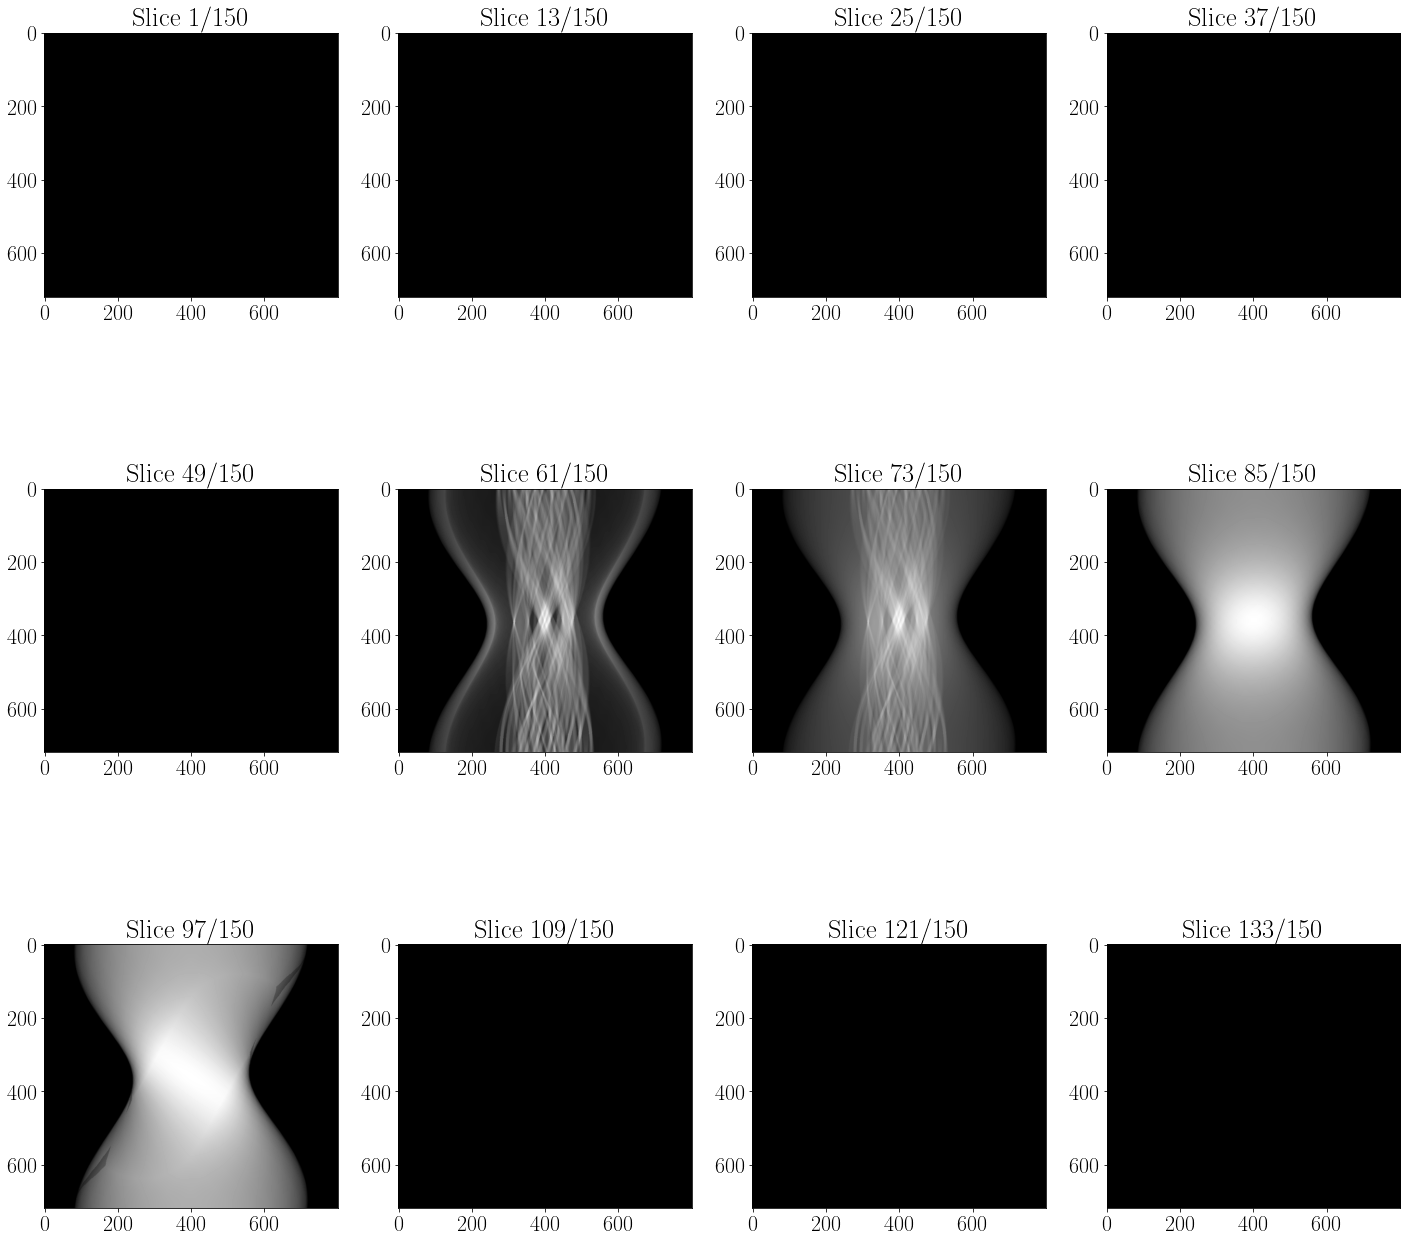

In [37]:
ncols = 4
nrows = 3

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id], cmap='gray')
        
plt.tight_layout()

In [38]:
if not os.path.exists("CT-volume.mha"):
    theta_rad = np.array(theta_deg) * math.pi / 180

    CT_volume_in_mu = recons(minus_log_projs, -theta_rad)
    
    sitk_image = sitk.GetImageFromArray(CT_volume_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * CT_volume_in_mu.shape[2] / 2.0,
                          -pixel_width * CT_volume_in_mu.shape[1] / 2.0,
                          -pixel_height * CT_volume_in_mu.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, "CT-volume.mha", useCompression=True)

else:
    sitk_image = sitk.ReadImage("CT-volume.mha")
    CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

del sinograms # Not needed anymore
del minus_log_projs # Not needed anymore

Display the CT slices

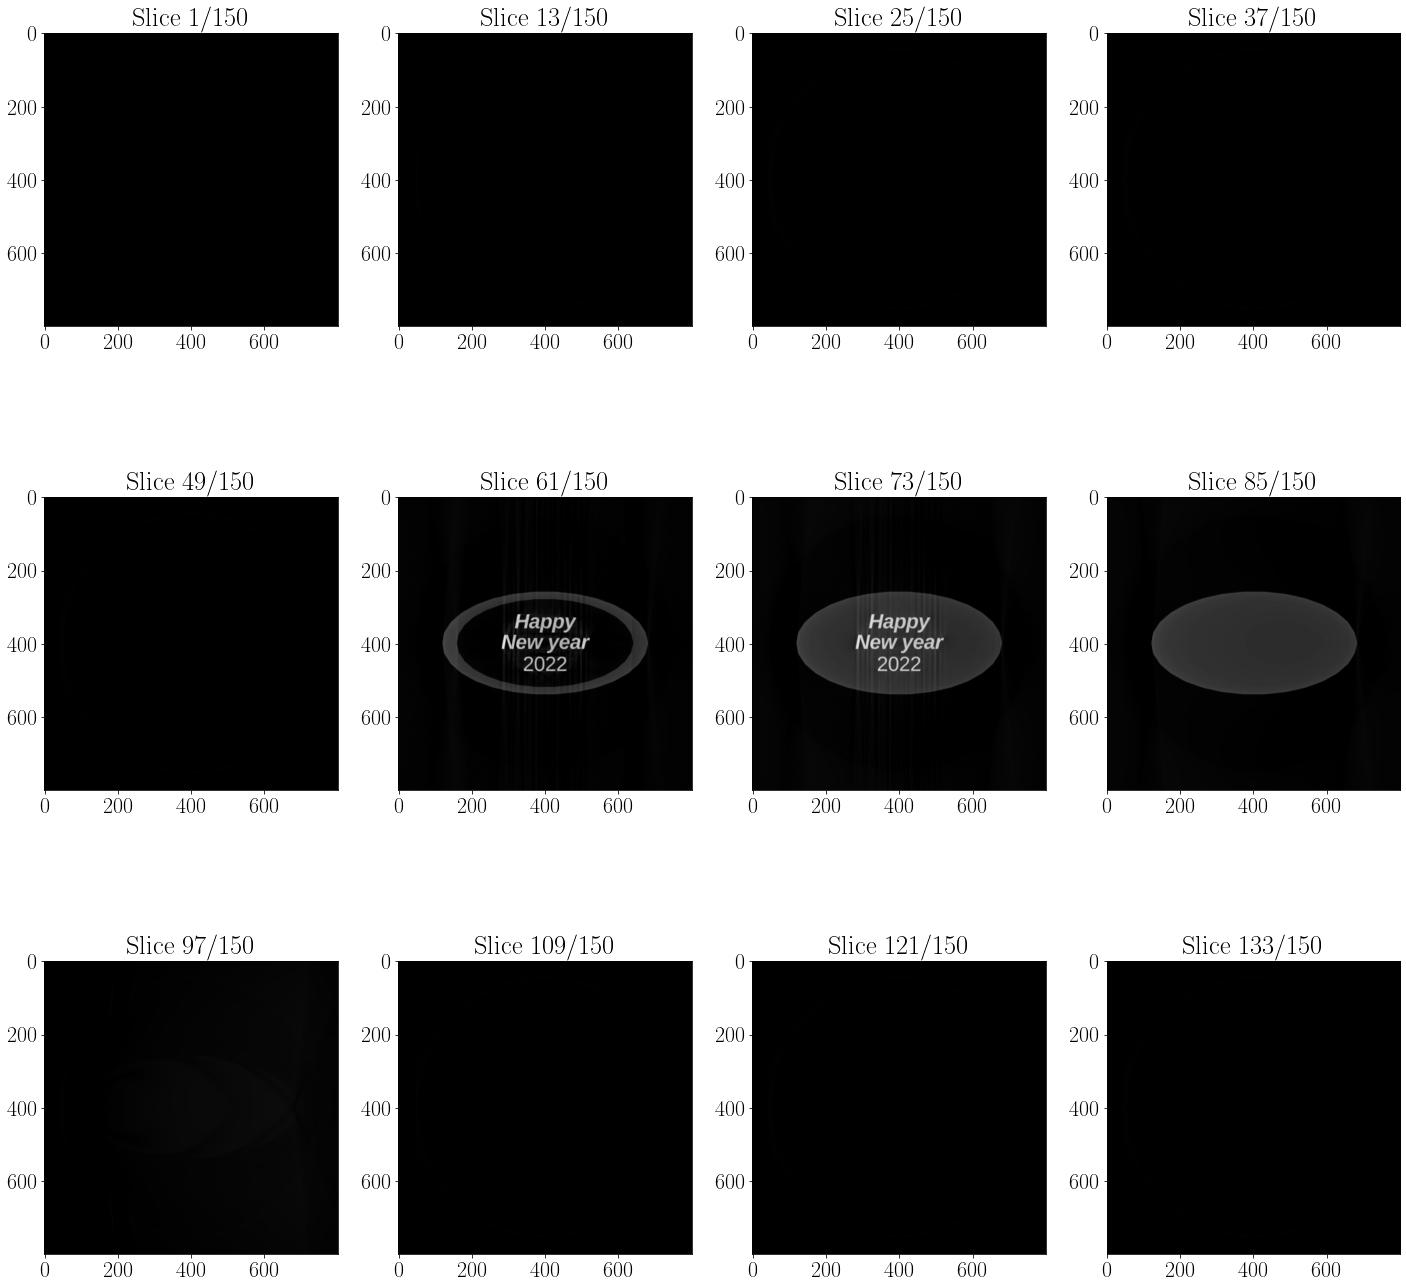

In [39]:
ncols = 4
nrows = 3

step = int(CT_volume_in_mu.shape[0] / (ncols * nrows))
slices = range(0, int(CT_volume_in_mu.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(CT_volume_in_mu.shape[0]))
        ax.imshow(np.rot90(CT_volume_in_mu[slice_id]), cmap='gray', vmin=0, vmax=CT_volume_in_mu.max())
        
plt.tight_layout()

## Volume rendering of the CT data

In [40]:
test = CT_volume_in_mu < 0
CT_volume_in_mu[test] = 0

In [41]:
normalised_CT_volume = ((CT_volume_in_mu - CT_volume_in_mu.min()) / (CT_volume_in_mu.max() - CT_volume_in_mu.min())).astype(np.single)
normalised_CT_volume = zoom(normalised_CT_volume, (0.5, 0.5, 0.5))

In [42]:
del CT_volume_in_mu # No longer needed

In [43]:
plot = k3d.plot()

# loading data to the `density` array
cmap = k3d.colormaps.matplotlib_color_maps.jet

volume = k3d.volume(
    normalised_CT_volume,
    alpha_coef=5,
    shadow='dynamic',
    samples=300,
    shadow_res=128,
    shadow_delay=50,
    color_range=[-0.05, 0.75],
    color_map=(np.array(cmap).reshape(-1,4)).astype(np.float32)
)

size = np.array(sitk_image.GetSize()) * np.array(sitk_image.GetSpacing())

volume.transform.bounds = [-size[0] / 2, size[0] / 2,
                           -size[1] / 2, size[1] / 2,
                           -size[2] / 2, size[2] / 2]

plot = k3d.plot(camera_auto_fit=True, height=400)

plot += volume
plot.display()
plot.camera = [-2.2173590358628807, -79.14858865199245,  -167.81797977511997,
                0.0,                  0.0,                  0.0,
                0.9976308234035427,  -0.01585900981119198, -0.06694200477249009]

Output()

In [44]:
fname = 'volume_rendering.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot()

    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

## All done

Destroy the window

In [45]:
gvxr.destroyAllWindows()

gvxrStatus:	Destroy all the windows
gvxrStatus:	Destroy window 0(0x55f6ac22f390)
